전이학습을 위한 파이썬 라이브러리를 임포트 한다. 

In [11]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, MaxPooling2D
from tensorflow.keras import datasets
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras import Input
from tensorflow.keras.layers import Dropout, BatchNormalization

CIFAR10 데이터셋을 불러온다. 

In [12]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()
print(train_images.shape)
print(train_labels.shape)

(50000, 32, 32, 3)
(50000, 1)


다운로드한 이미지를 시각화 한다. 

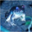

[6]


In [13]:
from google.colab.patches import cv2_imshow
import cv2  # Install opencv-python
cv2_imshow(train_images[0])
cv2.waitKey(2000)
cv2.destroyAllWindows()
print(train_labels[0])

미리 훈련이 된 신경망인 ResNet을 가져온다. 
trainable을 false로 한다. 
include_top도 false로 한다.  

In [14]:
base_model = ResNet50(include_top=False, pooling = 'avg' , input_shape = (32,32 ,3), weights = 'imagenet')
base_model.trainable = False
print(base_model.summary())

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 38, 38, 3)    0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 16, 16, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 16, 16, 64)   256         ['conv1_conv[0][0]']             
                                                                                           

label 데이터를 수치화 해준다. 라벨바이나리징과 같은 작업이다. 

In [16]:
print(train_labels[0])
print(test_labels[0])
input_y = tf.keras.utils.to_categorical(train_labels, 10)
test_y = tf.keras.utils.to_categorical(test_labels, 10)
print(input_y.shape, test_y.shape)
print(input_y[0])
print(test_y[0])

[6]
[3]
(50000, 10) (10000, 10)
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


전이학습을 위한 모델을 설계한다. 
모델은 기존 LesNet 컨버루션 모델에 우리가 사용할 NN레이어를 결합한다. 

In [17]:
inputs = Input(shape=(32,32,3))
x = tf.keras.layers.experimental.preprocessing.Resizing(32, 32)(inputs)
x = tf.keras.applications.resnet50.preprocess_input(inputs)
x = base_model(x, training = False)
x = Flatten()(x)								# Fully Connected에 온전하게 학습을 위해 펼쳐준다	
outputs = Dense(10, activation = 'softmax')(x)	# Softmax 함수로 10개 분류하는 분류기 
model_res = tf.keras.Model(inputs, outputs)	# model_res 란 이름의 인풋과 아웃풋이 정해진 모델 생성
print(model_res.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 tf.__operators__.getitem (S  (None, 32, 32, 3)        0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 32, 32, 3)        0         
                                                                 
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 10)                20490     
                                                             

pre-trained 모델인 ResNet과 사용자가 정의한 NN을 결합한 전이학습 모델을 구성한다. 

In [18]:
model_res.compile(optimizer = tf.keras.optimizers.Adam(learning_rate= 0.001),
                  loss = 'categorical_crossentropy',
                  metrics=['accuracy'])

전이학습 모델을 트레이닝 한다. 

In [19]:
model_res.fit(train_images, input_y, epochs = 10, validation_data=(test_images, test_y), batch_size= 256)

Epoch 1/10
196/196 [==============================] - 223s 1s/step - loss: 1.6468 - accuracy: 0.5428 - val_loss: 1.2778 - val_accuracy: 0.6034
Epoch 2/10
196/196 [==============================] - 207s 1s/step - loss: 1.0934 - accuracy: 0.6408 - val_loss: 1.1693 - val_accuracy: 0.6222
Epoch 3/10
196/196 [==============================] - 205s 1s/step - loss: 0.9619 - accuracy: 0.6749 - val_loss: 1.0919 - val_accuracy: 0.6388
Epoch 4/10
196/196 [==============================] - 205s 1s/step - loss: 0.9001 - accuracy: 0.6919 - val_loss: 1.0613 - val_accuracy: 0.6534
Epoch 5/10
196/196 [==============================] - 205s 1s/step - loss: 0.8658 - accuracy: 0.7018 - val_loss: 1.0695 - val_accuracy: 0.6546
Epoch 6/10
196/196 [==============================] - 205s 1s/step - loss: 0.8430 - accuracy: 0.7086 - val_loss: 1.0757 - val_accuracy: 0.6499
Epoch 7/10
196/196 [==============================] - 205s 1s/step - loss: 0.8252 - accuracy: 0.7138 - val_loss: 1.0784 - val_accuracy: 0.6536